<a href="https://colab.research.google.com/github/ongtiongheng/rfml/blob/master/flower_module2_solutions_with_attack_PGP_FGSM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload dataset to Google drive i.e. RML2016a

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Install the library code
!pip install --upgrade git+https://github.com/brysef/rfml.git
#extract to tmp folder only when not found
#![ ! -f "/tmp/RML2016.10a_dict.pkl" ] && tar -xf /content/drive/MyDrive/RML2016.10a.tar.bz2 -C /tmp
#check /tmp/ folder for dataset
#!ls -lah /tmp/RML*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/brysef/rfml.git to /tmp/pip-req-build-yzhumsqy
  Running command git clone -q https://github.com/brysef/rfml.git /tmp/pip-req-build-yzhumsqy


## Train/Evaluate a DNN for AMC

This notebook demonstrates how to create a neural network and a trainer in PyTorch to learn a signal classification task.  The reference dataset used is the RML2016.10A dataset for Automatic Modulation Classification

### Assumptions
- The dataset wrangling has already been completed (and is provided here)
- The classifier evaluation code (and the plotting) has already been completed

### Components Recreated in Tutorial
- Deep Neural Network Model defined in PyTorch
- Training Loop that trains for *n* epochs

### See Also
The code in this tutorial is a stripped down version of the code in ``rfml.nn.model.CNN`` and ``rfml.nn.train.StandardTrainingStrategy`` that simplifies discussion.  Further detail can be provided by directly browsing the source files for those classes.

## Install the library code and dependencies

In [114]:
# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Internal Includes
from rfml.data import Dataset, Encoder
from rfml.data.converters import load_RML201610A_dataset

from rfml.nbutils import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

from rfml.nn.eval import compute_accuracy, compute_accuracy_on_cross_sections, compute_confusion
from rfml.nn.eval.confusion import _confusion_matrix
from rfml.nn.model import Model

#Attack Includes
from rfml.attack import fgsm, pgd
from rfml.nn.eval import compute_accuracy
from rfml.data import build_dataset
from rfml.nn.model import build_model

from torch.utils.data import DataLoader

## Configuration

In [24]:
gpu = True       # Set to True to use a GPU for training
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = "/content/drive/MyDrive/RML2016.10a_dict.pkl" # Set to a file path if you've downloaded RML2016.10A locally

### Loading a Dataset

The dataset used is downloaded from DeepSig Inc. and provided under a Creative Commons lic

In [25]:
dataset = load_RML201610A_dataset(path=data_path)
print(len(dataset))
pprint(dataset.get_examples_per_class())

220000
{'8PSK': 20000,
 'AM-DSB': 20000,
 'AM-SSB': 20000,
 'BPSK': 20000,
 'CPFSK': 20000,
 'GFSK': 20000,
 'PAM4': 20000,
 'QAM16': 20000,
 'QAM64': 20000,
 'QPSK': 20000,
 'WBFM': 20000}


In [26]:
train, test = dataset.split(frac=0.3, on=["Modulation", "SNR"])
train, val = train.split(frac=0.05, on=["Modulation", "SNR"])

print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Validation Examples")
print("=================")
pprint(val.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 13280,
 'AM-DSB': 13280,
 'AM-SSB': 13280,
 'BPSK': 13280,
 'CPFSK': 13280,
 'GFSK': 13280,
 'PAM4': 13280,
 'QAM16': 13280,
 'QAM64': 13280,
 'QPSK': 13280,
 'WBFM': 13280}

Validation Examples
{'8PSK': 700,
 'AM-DSB': 700,
 'AM-SSB': 700,
 'BPSK': 700,
 'CPFSK': 700,
 'GFSK': 700,
 'PAM4': 700,
 'QAM16': 700,
 'QAM64': 700,
 'QPSK': 700,
 'WBFM': 700}

Testing Examples
{'8PSK': 6020,
 'AM-DSB': 6020,
 'AM-SSB': 6020,
 'BPSK': 6020,
 'CPFSK': 6020,
 'GFSK': 6020,
 'PAM4': 6020,
 'QAM16': 6020,
 'QAM64': 6020,
 'QPSK': 6020,
 'WBFM': 6020}


In [27]:
le = Encoder(["WBFM",
              "AM-DSB",
              "AM-SSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM16",
              "QAM64"],
             label_name="Modulation")
print(le)

WBFM: 0
AM-DSB: 1
AM-SSB: 2
CPFSK: 3
GFSK: 4
BPSK: 5
QPSK: 6
8PSK: 7
PAM4: 8
QAM16: 9
QAM64: 10



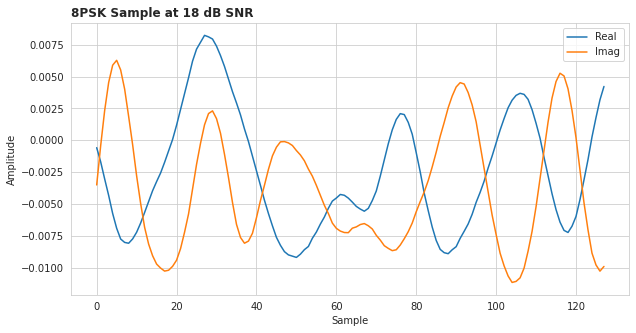

In [28]:
# Plot a sample of the data
# You can choose a different sample by changing
idx = 5
snr = 18.0
modulation = "8PSK"

mask = (dataset.df["SNR"] == snr) & (dataset.df["Modulation"] == modulation)
sample = dataset.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Creating a Neural Network Model
We are going to recreate a Convolutional Neural Network (CNN) based on the "VT_CNN2" Architecture.  This network is based off of a network for modulation classification first
introduced in [O'Shea et al.] and later updated by [West/Oshea] and [Hauser et al.]
to have larger filter sizes.

#### Citations
##### O'Shea et al.
T. J. O'Shea, J. Corgan, and T. C. Clancy, “Convolutional radio modulation recognition networks,” in International Conference on Engineering Applications of Neural Networks, pp. 213–226, Springer,2016.

##### West/O'Shea
N. E. West and T. O’Shea, “Deep architectures for modulation recognition,” in IEEE International Symposium on Dynamic Spectrum Access Networks (DySPAN), pp. 1–6, IEEE, 2017.

##### Hauser et al.
S. C. Hauser, W. C. Headley, and A. J.  Michaels, “Signal detection effects on deep neural networks utilizing raw iq for modulation classification,” in Military Communications Conference, pp. 121–127, IEEE, 2017.

In [29]:
class MyCNN(Model):
    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples=input_samples, n_classes=n_classes)
        # Batch x 1-channel x IQ x input_samples
        # Modifying the first convolutional layer to not use a bias term is a
        # modification made by Bryse Flowers due to the observation of vanishing
        # gradients during training when ported to PyTorch (other authors used
        # Keras).
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.n1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=80,
            kernel_size=(2, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.n2 = nn.BatchNorm2d(80)

        # Batch x Features
        self.dense1 = nn.Linear(80 * 1 * input_samples, 256)
        self.a3 = nn.ReLU()
        self.n3 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.n1(x)

        x = self.conv2(x)
        x = self.a2(x)
        x = self.n2(x)

        # Flatten the input layer down to 1-d by using Tensor operations
        x = x.contiguous()
        x = x.view(x.size()[0], -1)

        x = self.dense1(x)
        x = self.a3(x)
        x = self.n3(x)

        x = self.dense2(x)

        return x

In [118]:
model = MyCNN(input_samples=128, n_classes=11)
print(model)

MyCNN(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (n1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 80, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (n2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=10240, out_features=256, bias=True)
  (a3): ReLU()
  (n3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=11, bias=True)
)
----------------------
Trainable Parameters: 2914299
Fixed Parameters: 0
Total Parameters: 2914299
----------------------



### Implementing a Training Loop

In [31]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 5, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            train_loss = self._train_one_epoch(
                model=model, data=train_data, loss_fn=criterion, optimizer=optimizer
            )
            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.eval()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

In [32]:
trainer = MyTrainingStrategy(gpu=gpu)
print(trainer)

MyTrainingStrategy(lr=0.001, n_epochs=5, gpu=True)


### Putting it All Together

In [33]:
train_loss, val_loss = trainer(model=model,
                               training=train,
                               validation=val,
                               le=le)

On Epoch 0 the training loss was 1.4165945569952052
---- validation loss was 1.2580820620059967
On Epoch 1 the training loss was 1.1988484067516727
---- validation loss was 1.1928621381521225
On Epoch 2 the training loss was 1.1318046254711551
---- validation loss was 1.1939619332551956
On Epoch 3 the training loss was 1.0505323610105715
---- validation loss was 1.2183491066098213
On Epoch 4 the training loss was 0.9098600645165343
---- validation loss was 1.3016280345618725


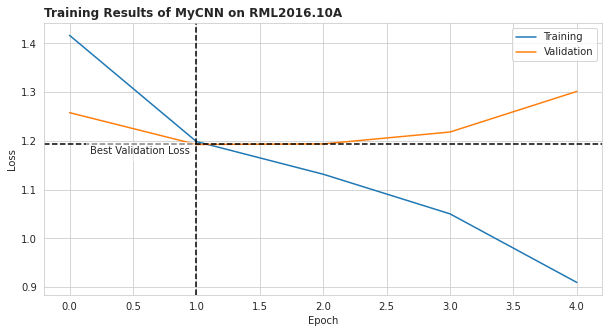

In [34]:
title = "Training Results of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_convergence(train_loss=train_loss, val_loss=val_loss, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Testing the Trained Model

In [35]:
acc = compute_accuracy(model=model, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.5353


In [66]:

type(test)


rfml.data.dataset.Dataset

acc_vs_snr: [0.4684385382059801, 0.7834491090305044, 0.66626396858955, 0.7408637873754153, 0.0960434913923286, 0.7919057686499547, 0.11023859861069163, 0.33162186650558745, 0.160676532769556, 0.24312896405919662, 0.7952280277861673, 0.093325279371791, 0.7952280277861673, 0.8109332527937179, 0.11718514044095439, 0.79855028692238, 0.557535487768046, 0.7919057686499547, 0.7798248263364542, 0.7743884022953791]
snr: [-6, 8, -2, 0, -16, 12, -18, -8, -12, -10, 14, -20, 16, 10, -14, 18, -4, 6, 4, 2]
data: <rfml.data.dataset.Dataset object at 0x7ff43d311690>


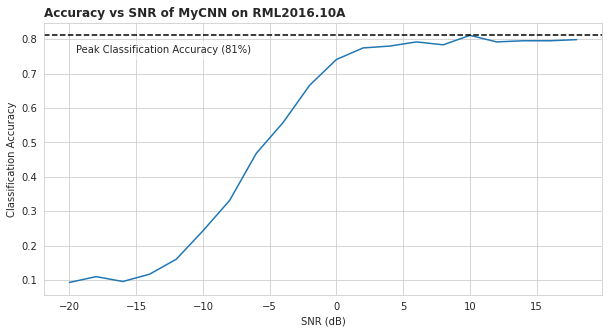

In [36]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

print("acc_vs_snr: {acc_vs_snr}".format(acc_vs_snr=acc_vs_snr))
print("snr: {snr}".format(snr=snr))
print("data: {data}".format(data=test))

title = "Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

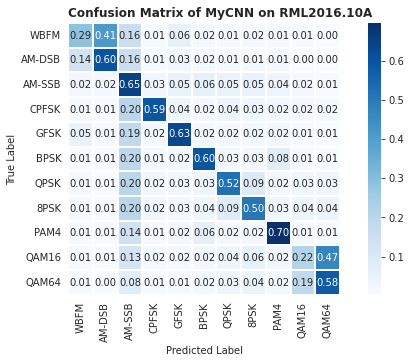

In [37]:
cmn = compute_confusion(model=model, data=test, le=le)

title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

Attack fgsm before and after

In [48]:

#_, _, test, le = build_dataset(dataset_name=dataset, test_pct=0.9)
mask = test.df["SNR"] >= 18
#model = build_model(model_name="CNN", input_samples=128, n_classes=len(le))
#model.load("cnn.pt")

## No Attack
acc = compute_accuracy(model=model, data=test, le=le, mask=mask)
print("Normal (no attack) Accuracy on Dataset: {:.3f}".format(acc))

# print(model)

## ATTACK
spr = 10  # dB
right = 0
total = 0
dl = DataLoader(test.as_torch(le=le, mask=mask), shuffle=True, batch_size=512)
for x, y in dl:
    adv_x = fgsm(x, y, spr=spr, input_size=128, sps=8, net=model)
    predictions = model.predict(adv_x)
    right += (predictions == y).sum().item()
    total += len(y)

adv_acc = float(right) / total
print("Adversarial Accuracy with SPR of {} dB attack: {:.3f}".format(spr, adv_acc))
print("FGSM Degraded Model Accuracy by {:.3f}".format(acc - adv_acc))





Normal (no attack) Accuracy on Dataset: 0.799
Adversarial Accuracy with SPR of 10 dB attack: 0.121
FGSM Degraded Model Accuracy by 0.677


Attack pgd before and after

In [115]:
def fgsm(x, y, input_size, net, spr, sps):
    p = compute_signed_gradient(x=x, y=y, input_size=input_size, net=net)
    p = scale_perturbation(sg=p, spr=spr, sps=sps)
    
    return x + p


def compute_signed_gradient(x, y, input_size, net):
    # Ensure that the gradient is tracked at the input, add some noise to avoid any
    # actual zeros in the signal (dithering), and then ensure its the proper shape
    x.requires_grad = True
    _x = _dither(x)

    # Put the inputs/outputs onto the most probable device that the model is currently
    # on -- this could fail if the model gets split amongst multiple devies, but, that
    # doesn't happen in this code.
    _x = _x.to(net.device)
    y = y.to(net.device)

    # Perform forward/backward pass to get the gradient at the input
    _y = net(_x)
    loss = cross_entropy(_y, y)
    loss.backward()

    # Take the sign of the gradient that can be scaled later
    ret = torch.sign(x.grad.data)

    return ret


def scale_perturbation(sg, spr, sps):
    if spr == np.inf:
        return sg * 0
    multiplier = pow(10, -spr / 10.0)
    multiplier = multiplier / (2 * sps)
    multiplier = pow(multiplier, 0.5)

    return sg * multiplier


def _dither(x):
    snr = 100
    voltage = pow(pow(10.0, -snr / 10.0), 0.5)

    noise = x.data.new(x.size()).normal_(0.0, voltage)
    return x + noise


def _normalize(x):
    power = energy(x)
    # Make the dimensions match because broadcasting is too magical to
    # understand in its entirety... essentially want to ensure that we
    # divide each channel of each example by the sqrt of the power of
    # that channel/example pair
    power = power.view([power.size()[0], power.size()[1], 1, 1])

    return x / torch.sqrt(power)


def _sanity_check(desired_spr, adv_x, x):
    signal_power = energy(x)
    perturbation_power = energy(adv_x - x)
    _spr = 10*torch.log10(signal_power / perturbation_power)
    _spr = _spr.detach().numpy().mean()
    if np.abs(_spr - desired_spr) > 0.5:
        raise RuntimeError("Calculated SPR and desired SPR does not match: "
                           "Desired SPR={:0.2f}dB, Calculated SPR={:0.2f}dB, "
                           "Signal Power={:0.2f}dB, Perturbation Power={:0.2f}dB".format(
                               desired_spr,
                               _spr,
                               10.0*np.log10(signal_power.detach().numpy().mean()),
                               10.0*np.log10(perturbation_power.detach().numpy().mean()))
                          )

In [119]:
#_, _, test, le = build_dataset(dataset_name=dataset, test_pct=0.9)
mask = test.df["SNR"] >= 18
#model = build_model(model_name="CNN", input_samples=128, n_classes=len(le))
#model.load("cnn.pt")

## No Attack
acc = compute_accuracy(model=model, data=test, le=le, mask=mask)
print("Normal (no attack) Accuracy on Dataset: {:.3f}".format(acc))


## ATTACK
spr = 10  # dB
right = 0
total = 0
dl = DataLoader(test.as_torch(le=le, mask=mask), shuffle=True, batch_size=512)
k = 7 # Number of iterations to use for the attack
for x, y in dl:
    adv_x = pgd(x, y, k=k, net=model, spr=spr, input_size=128, sps=8)
    predictions = model.predict(adv_x)
    right += (predictions == y).sum().item()
    total += len(y)

adv_acc = float(right) / total
print("Adversarial Accuracy with SPR of {} dB attack: {:.3f}".format(spr, adv_acc))
print("PGD Degraded Model Accuracy by {:.3f}".format(acc - adv_acc))

Normal (no attack) Accuracy on Dataset: 0.091
Adversarial Accuracy with SPR of 10 dB attack: 0.085
PGD Degraded Model Accuracy by 0.006


LSTM Model

In [69]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
def input_data(seq, ws):
  output = []   
  L = len(seq)
  for i in range((L) - ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    print(i)
    output.append((window, label))
 
  return output

In [78]:
window_size = 40
train_data = input_data(sample, window_size)

In [79]:
class myLSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=50, out_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size )
    self.linear = nn.Linear(hidden_size, out_size)
    self.hidden = (torch.zeros(1,1,hidden_size ) , torch.zeros(1,1,hidden_size)  )
 
  def forward(self, seq):
    lstm_out, self.hidden = self.lstm(seq.view( len(seq),1,-1 ), self.hidden )
    pred = self.linear(lstm_out.view(  len(seq) ,-1 ))  
    return pred[-1]

In [97]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

https://datahacker.rs/011-pytorch-rnn-with-pytorch/#Defining-the-LSTM-model-using-PyTorch


In [101]:
#model = myLSTM()
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print(model)

LSTM(
  (lstm1): LSTMCell(1, 64)
  (lstm2): LSTMCell(64, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [85]:
for p in model.parameters():
  print(p.numel())

200
10000
200
200
50
1


In [86]:
type(mask)

pandas.core.series.Series

In [89]:
# x = torch.linspace(0,799, 800)
# y = torch.sin(x * 2 * np.pi / 40)

In [93]:
# print(x)

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [94]:
# print(y)

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
         7.0711e-01,  5.8779e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
        -8.7423e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5106e-01, -8.9101e-01, -8.0902e-01,
        -7.0711e-01, -5.8779e-01, -4.5399e-01, -3.0902e-01, -1.5643e-01,
         1.7485e-07,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
         7.0711e-01,  5.8778e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
        -2.3850e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5

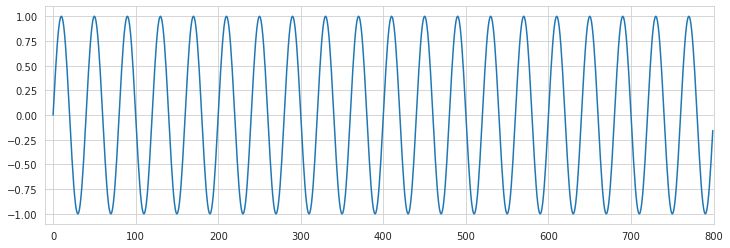

In [90]:
plt.figure(figsize = (12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy() )

In [91]:
test_size = 40
# train_set = y[:-test_size]
# test_set = y[-test_size:]

In [92]:
# print(train_set)

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
         7.0711e-01,  5.8779e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
        -8.7423e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5106e-01, -8.9101e-01, -8.0902e-01,
        -7.0711e-01, -5.8779e-01, -4.5399e-01, -3.0902e-01, -1.5643e-01,
         1.7485e-07,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
         7.0711e-01,  5.8778e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
        -2.3850e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5

In [111]:
train_set = sample

In [113]:
print(sample.shape)

(2, 128)


torch.Size([0, 1])

In [110]:
# y = (100, 1000)
train_input = torch.from_numpy(y[:-1,1:]) # (97, 999)
train_target = torch.from_numpy(y[1:, 1:]) # (97, 999)

IndexError: ignored

In [102]:
epochs = 10
future = 40
for i in range(epochs):
  for seq, y_train in train_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                    torch.zeros(1,1,model.hidden_size))
    
    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
 
  # print(f"Epoch {i} Loss {loss.item()} ")
  preds = train_set[-window_size:].tolist()
 
  for f in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
      model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                      torch.zeros(1,1,model.hidden_size))
      preds.append(model(seq).item())
 
  loss = criterion(torch.tensor(preds[-window_size :]), y[760:] )
  print(f'Performance on test range: {loss}')

AttributeError: ignored